In [1]:
%matplotlib inline

import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error as mse

from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from pathlib import PurePath

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

In [4]:
NUM_FRAMES = 9   # number of timestep
NUM_COMPONENTS = 3
INPUT_STEP = 3
OUTPUT_STEP = 1

torch.manual_seed(0)

Our simulation managed to create `NUM_FRAMES` in csv forms

In [5]:
data_path = [0]*NUM_FRAMES
dfs = [0]*NUM_FRAMES
for i in range(0,NUM_FRAMES):
    data_path[i] = PurePath("data", f"data_{i}.csv")
    dfs[i]=pd.read_csv(str(data_path[i]))

For each frame, we have a DF that looks like bellow

In [6]:
dfs[0]

,Time,Points:0,Points:1,Points:2,U:0,U:1,U:2,k,nut,omega,p
0,0.002,0.001548,-0.028337,0.216410,-0.059335,0.000652,14.887,2.080500,0.000021,88954.0000,1.13810
1,0.002,0.027196,-0.008778,0.151550,0.000000,0.000000,0.000,2.912600,0.000000,135740.0000,1.34340
2,0.002,-0.011953,-0.003984,0.190230,0.001542,-0.000173,20.182,0.003749,0.001111,3.3743,1.18980
3,0.002,-0.011953,0.000000,0.202190,0.002667,-0.000360,20.182,0.003750,0.001082,3.3745,1.14850
4,0.002,-0.011953,0.013945,0.010937,0.031155,-0.039295,20.069,0.003756,0.000076,3.4181,1.90970
...,...,...,...,...,...,...,...,...,...,...,...
272546,0.002,-0.013945,-0.007969,0.042813,0.007941,-0.003066,20.137,0.003767,0.000130,3.6325,1.70750
272547,0.002,-0.001992,-0.019922,0.172300,0.001229,-0.002522,20.176,0.003761,0.000280,3.4517,1.25660
272548,0.002,0.000896,0.027621,0.378840,-0.019208,-0.060298,20.168,0.089455,0.000021,4539.8000,0.53586
272549,0.002,0.021583,0.017966,0.459840,-0.007281,-0.004641,19.464,0.643610,0.000023,26273.0000,0.22404


We concat every `p` of the first 5 frames and try to predict the rest of the frames. Matrix is a long one, has the shape of `(m=5, n=272k)`
$$\begin{bmatrix} C_{1,1} & C_{1,2} & \cdots & C_{1,n} \\ C_{2,1} & C_{2,2} & \cdots & C_{2,n} \\ \vdots & \vdots & \vdots & \vdots \\ C_{m,1} & C_{m,2} & \cdots & C_{m,n} \end{bmatrix}$$

In [7]:
# the same poinst appear in the same order in all frames
for i in range(2,NUM_FRAMES):
    pd.testing.assert_frame_equal(dfs[1][["Points:0", "Points:1", "Points:2"]], dfs[i][["Points:0", "Points:1", "Points:2"]])

All points coordinates are the same accross time

In [8]:
p_data = dfs[1]['p']
for i in range(2,NUM_FRAMES):
    p_data = pd.concat([p_data, dfs[i]['p']], axis=1)
p_data

,p,p,p,p,p,p,p,p
0,0.84425,0.79001,0.78038,0.77933,0.78145,0.78515,0.79059,0.79253
1,0.97069,0.90072,0.88918,0.88847,0.89309,0.89922,0.90522,0.90721
2,0.85257,0.79214,0.78047,0.78039,0.78258,0.78757,0.79337,0.79534
3,0.82532,0.76763,0.75646,0.75621,0.75816,0.76259,0.76819,0.77015
4,1.42280,1.35280,1.34860,1.35360,1.35940,1.36570,1.37170,1.37360
...,...,...,...,...,...,...,...,...
272546,1.20400,1.13310,1.12880,1.13380,1.13970,1.14590,1.15190,1.15390
272547,0.89954,0.83523,0.82372,0.82312,0.82642,0.83216,0.83812,0.84011
272548,0.41946,0.40175,0.40012,0.40177,0.40273,0.40351,0.40362,0.40375
272549,0.20627,0.20666,0.20909,0.21142,0.21322,0.21445,0.21562,0.21586


In [9]:
p_learn = p_data.values[:,:5]

In [10]:
p_learn

array([[0.84425, 0.79001, 0.78038, 0.77933, 0.78145],
       [0.97069, 0.90072, 0.88918, 0.88847, 0.89309],
       [0.85257, 0.79214, 0.78047, 0.78039, 0.78258],
       ...,
       [0.41946, 0.40175, 0.40012, 0.40177, 0.40273],
       [0.20627, 0.20666, 0.20909, 0.21142, 0.21322],
       [1.202  , 1.1312 , 1.127  , 1.132  , 1.1378 ]])

In [11]:
p_learn = p_learn.T

In [12]:
p_learn.shape

(5, 272551)

## PCA

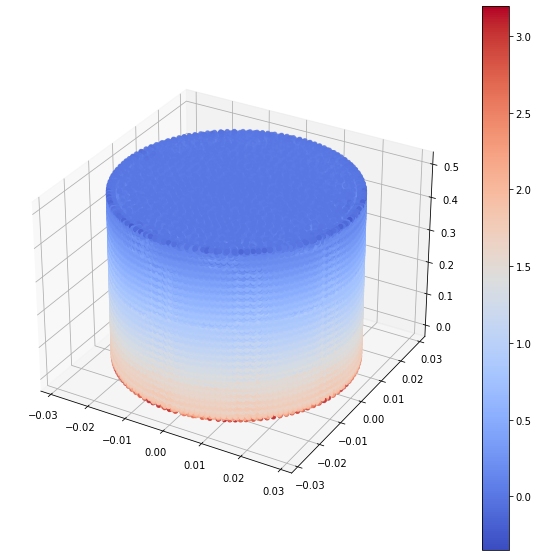

In [13]:
# creating figures
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
img = ax.scatter(dfs[0]["Points:0"], dfs[0]["Points:1"], dfs[0]["Points:2"], c=dfs[0]['p'], cmap=cm.coolwarm)
color_map = cm.ScalarMappable(cmap=cm.coolwarm)
color_map.set_array(dfs[0]['p'])
plt.colorbar(color_map)
plt.show()

### Try with multiple frame

In [14]:
pca = PCA(n_components=3)

In [15]:
pca.fit(p_learn)

PCA(n_components=3)

In [16]:
pca.components_

array([[ 2.19398877e-03,  2.77901978e-03,  2.45378759e-03, ...,
         6.35163739e-04, -1.39058476e-04,  2.48527255e-03],
       [ 2.17404963e-03,  1.82253094e-03,  2.33458903e-03, ...,
        -5.55165030e-04, -2.04781625e-03, -2.80287045e-03],
       [ 5.12082377e-04, -9.63115329e-04, -6.59563771e-04, ...,
         6.52604431e-05, -1.22277009e-03,  1.03331934e-03]])

In [17]:
pca.explained_variance_

array([1.59279798e+02, 1.39469696e+00, 5.49242552e-02])

**Q:** Aren't the eigenvectors here of the space variance, not time? We are interested in time variant though.

## Reconstructing the original data
Since we have the eigenvalues and eigenvectors of the covariance matrix of the pressure data (PCA), we can reconstruct the original data. We first tries the provided version of `sklearn`, and then reimplement our own

In [18]:
transformed_data = pca.transform(p_learn)

In [20]:
reconstructed_sklearn = pca.inverse_transform(transformed_data)

In [22]:
mse(reconstructed_sklearn, p_learn, squared=False)

0.00012202006519015159

In [50]:
def reconstruct(data):
    reconstructed = pca.inverse_transform(data)
    print(mse(reconstructed[5:], p_data.T[5:], squared=False))

## Learning based on transformed data

In [23]:
transformed_data[INPUT_STEP]

array([-6.44030644, -0.68051572,  0.11282322])

In [24]:
srcs = [transformed_data[:INPUT_STEP], transformed_data[1:INPUT_STEP+1]]
tgts = [transformed_data[INPUT_STEP].reshape((3,1)), transformed_data[INPUT_STEP].reshape((3,1))]

In [25]:
def train(model):
    model.train()
    loss = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    for epoch in range(3):  # loop over the dataset multiple times
        for i in range(len(srcs)):
            running_loss = 0.0
            src = torch.unsqueeze(torch.FloatTensor(srcs[i]), dim=0)
            tgt = torch.unsqueeze(torch.FloatTensor(tgts[i]), dim=0)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs, _ = lstm(src)
            l = loss(outputs, tgt)
            l.backward()
            optimizer.step()

            # print statistics
            running_loss += l
            print(f'[{epoch + 1}] loss: {running_loss / 2000:}')
    return model  

### LSTM

In [26]:
lstm = nn.LSTM(INPUT_STEP, OUTPUT_STEP, 2)
lstm = train(lstm)

[1] loss: 0.006834184750914574
[1] loss: 0.006959259510040283
[2] loss: 0.006833771243691444
[2] loss: 0.00695915287360549
[3] loss: 0.006833398249000311
[3] loss: 0.006959044840186834


In [27]:
lstm.eval()
lstm_eval = transformed_data.copy()
for i in range(4, p_data.shape[1]-1):
    print(lstm_eval.shape)
    predict, _ = lstm(torch.unsqueeze(torch.FloatTensor(lstm_eval[-2-INPUT_STEP:-2]), 0))                               
    print(predict.shape)
    lstm_eval = np.append(lstm_eval, predict.squeeze(2).detach().numpy(), axis=0)  # append prediction 

(5, 3)
torch.Size([1, 3, 1])
(6, 3)
torch.Size([1, 3, 1])
(7, 3)
torch.Size([1, 3, 1])


In [51]:
reconstruct(lstm_eval)

0.004563250385318567


### Transformer

In [28]:
transformed_data.shape

(5, 3)

In [29]:
transformed_data

array([[22.45347979, -0.05466261,  0.0423173 ],
       [-3.93510173,  1.70516747, -0.23052152],
       [-7.27555481,  0.44631166,  0.31081673],
       [-6.44030644, -0.68051572,  0.11282322],
       [-4.80251681, -1.41630081, -0.23543573]])

We will learn based on this transformed data

In [30]:
reconstructed_sklearn = pca.inverse_transform(np.random.random((10,3)))

In [31]:
reconstructed_sklearn.shape, p_learn.shape

((10, 272551), (5, 272551))

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [33]:
loss = nn.MSELoss()
transformer_model = nn.Transformer(nhead=NUM_COMPONENTS, num_encoder_layers=4,   # d_model divisible by nhead
                                   d_model=NUM_COMPONENTS, batch_first=True).to(device)
optimizer = optim.Adam(transformer_model.parameters(), lr=0.0001)

In [34]:
transformer_model = train(transformer_model)

[1] loss: 0.006833032239228487
[1] loss: 0.006958989426493645
[2] loss: 0.006833032239228487
[2] loss: 0.006958989426493645
[3] loss: 0.006833032239228487
[3] loss: 0.006958989426493645


## Reconstruct 

In [35]:
type(p_data)

pandas.core.frame.DataFrame

In [36]:
transformed_data.shape

(5, 3)

In [37]:
transformer_model.eval()
transformer_eval = transformed_data.copy()
for i in range(4, p_data.shape[1]-1):
    print(transformer_eval.shape)
    predict = transformer_model(torch.unsqueeze(torch.FloatTensor(transformer_eval[-2-INPUT_STEP:-2]), 0),  # INPUT_STEP steps before
                               torch.unsqueeze(torch.FloatTensor(transformer_eval[-1:]), 0))
    print(predict.shape)
    transformer_eval = np.append(transformer_eval, predict[0].detach().numpy(), axis=0)  # append prediction and 

(5, 3)
torch.Size([1, 1, 3])
(6, 3)
torch.Size([1, 1, 3])
(7, 3)
torch.Size([1, 1, 3])


In [48]:
transformer_eval.shape

(8, 3)

In [52]:
reconstruct(transformer_eval)

0.006454510468586366
